# Forecasting with SARIMAX

**S**easonal **A**uto-**R**egressive **I**ntegrated **M**oving **A**verage e**X**ogenous models are effective tools for forecasting timeseries data. SARIMAX models are highly flexible to timeseries forecasting problems: these models are able to capture the autoregressive (AR) and moving average (MA) components of timeseries values, while addressing non-stationarity through differencing (i.e., integrating the timeseries), able to incorporate seasonal variation, and include exogenous co-variates when available. These various capabilities make ARIMA models especially flexible, which is why they are used across diverse industries that rely on timeseries forecasting, from financial institutions to weather services to retailers.

## Setup

Data & package setup steps. Run this first!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Stationarity

_A distribution of the time series data is stationary when the mean, variance, and autocorrelation do not change with time_. Modelling a timeseries with ARIMA _requires_ that the data are stationary (do not worry: non-stationary processes may often be transformed into stationary ones). Stationarity has 3 dimensions:

## Trend Stationarity

A time series trend is stationary when the mean does not change over time. This further means the average slope is neither positive nor negative.

/tmp/ipykernel_12223/1730843404.py:31: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  axes[1].plot(date_range, p(time_index), color='#4CAF50', linestyle='--', linewidth=2, label=f'Trend Line (Slope: {z[0]:.4f})')


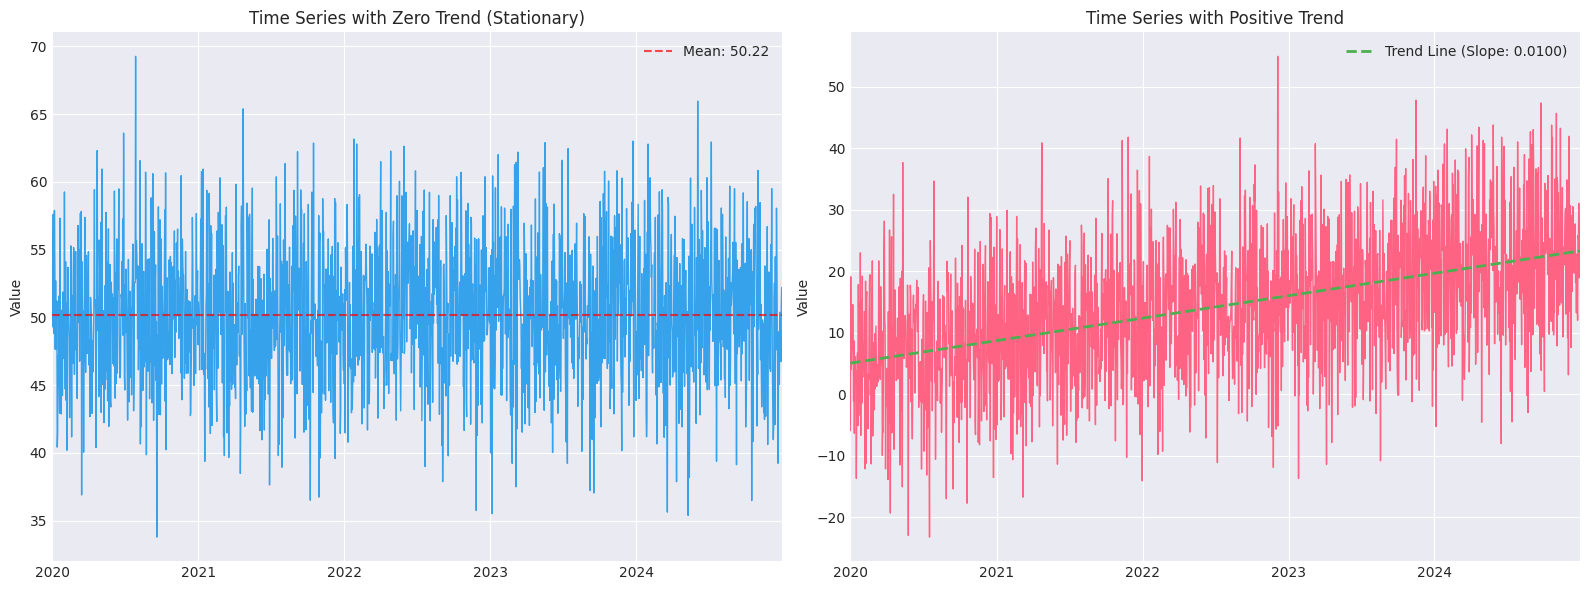

In [35]:
# Define the Date Range 
date_range = pd.date_range(start='2020-01-01', periods=1826, freq='D')

# Create Time Series Data with Zero Trend (Stationary)
np.random.seed(42) # for reproducibility
zero_trend_data = 50 + np.random.normal(loc=0, scale=5, size=len(date_range))
ts_zero_trend = pd.Series(zero_trend_data, index=date_range)

# This series is modeled as an increasing line (t/100) plus random noise (std=10).
time_index = np.arange(len(date_range))
positive_trend_data = (time_index / 100) + np.random.normal(loc=5, scale=10, size=len(date_range))
ts_positive_trend = pd.Series(positive_trend_data, index=date_range)

# Create a single figure with two subplots, arranged side-by-side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6)) #
plt.style.use('seaborn-v0_8-darkgrid')

# --- Plot 1: Zero Trend ---
ts_zero_trend.plot(ax=axes[0], title='Time Series with Zero Trend (Stationary)', color='#36A2EB', linewidth=1)
axes[0].set_ylabel('Value')
# Add a horizontal line to visualize the constant mean
axes[0].axhline(ts_zero_trend.mean(), color='red', linestyle='--', alpha=0.7, label=f'Mean: {ts_zero_trend.mean():.2f}')
axes[0].legend()

# --- Plot 2: Positive Trend ---
ts_positive_trend.plot(ax=axes[1], title='Time Series with Positive Trend', color='#FF6384', linewidth=1)
axes[1].set_ylabel('Value')
# Add a trend line (simple linear regression for visualization)
z = np.polyfit(np.array(time_index), np.array(ts_positive_trend.values), 1)
p = np.poly1d(z)
axes[1].plot(date_range, p(time_index), color='#4CAF50', linestyle='--', linewidth=2, label=f'Trend Line (Slope: {z[0]:.4f})')
axes[1].legend()

# Adjust layout to prevent subplot titles and labels from overlapping
plt.tight_layout() #
plt.show()

## Variance Stationarity

A stationary timeseries variance does not change with time.

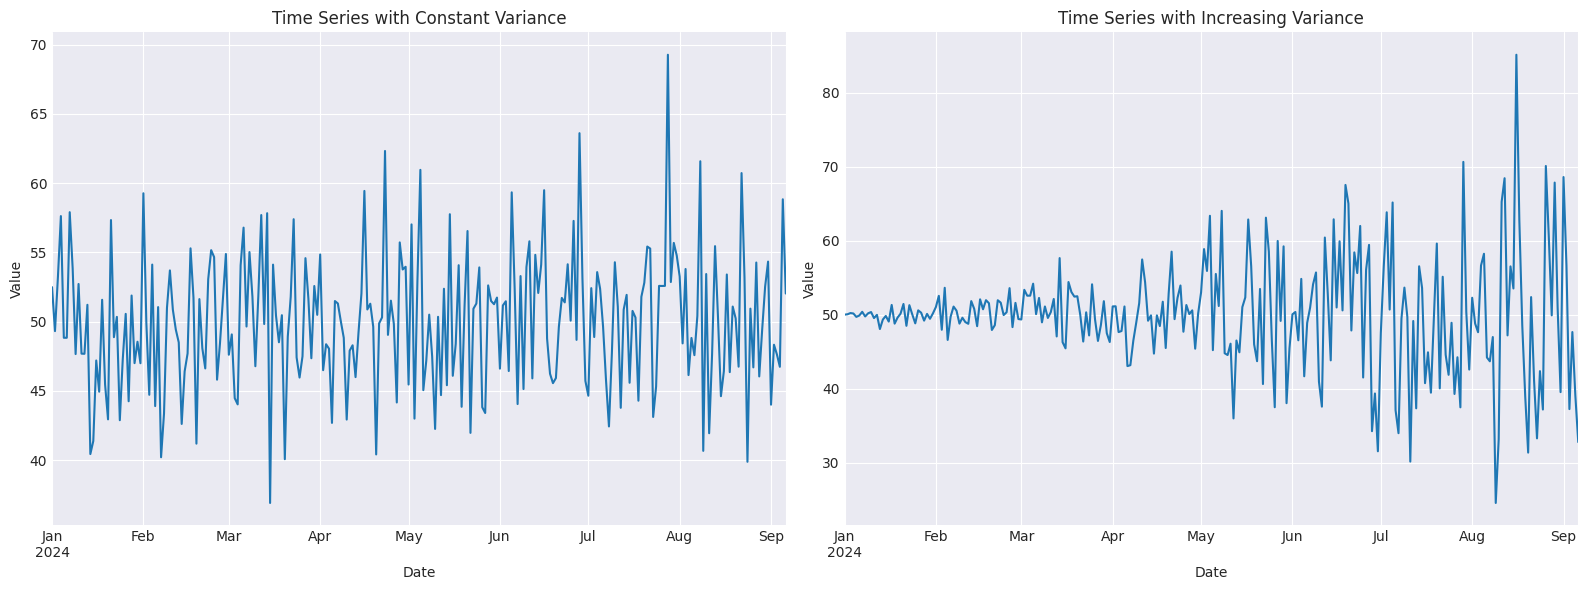

In [14]:
# Generate data for a time series with constant variance
np.random.seed(42)  # For reproducibility
dates = pd.date_range(start='2024-01-01', periods=250, freq='D')
mean_level = 50
constant_variance_data = pd.Series(
    mean_level + np.random.normal(0, 5, size=len(dates)),
    index=dates
)

# Generate data for a time series with increasing variance
increasing_variance_data = pd.Series(
    mean_level + np.random.normal(0, np.arange(len(dates)) / 20, size=len(dates)),
    index=dates
)

# Create a DataFrame to hold both series
df = pd.DataFrame({
    'constant_variance': constant_variance_data,
    'increasing_variance': increasing_variance_data
})

# Plot the time series
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Plot the constant variance time series
df['constant_variance'].plot(ax=axes[0], title='Time Series with Constant Variance')
axes[0].set_ylabel('Value')
axes[0].set_xlabel('Date')

# Plot the increasing variance time series
df['increasing_variance'].plot(ax=axes[1], title='Time Series with Increasing Variance')
axes[1].set_ylabel('Value')
axes[1].set_xlabel('Date')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## Auto-Correlation Stationarity

In a stationary timeseries, the relationship between values at time $t$ and $t-n$ remain constant across all time, $t$.

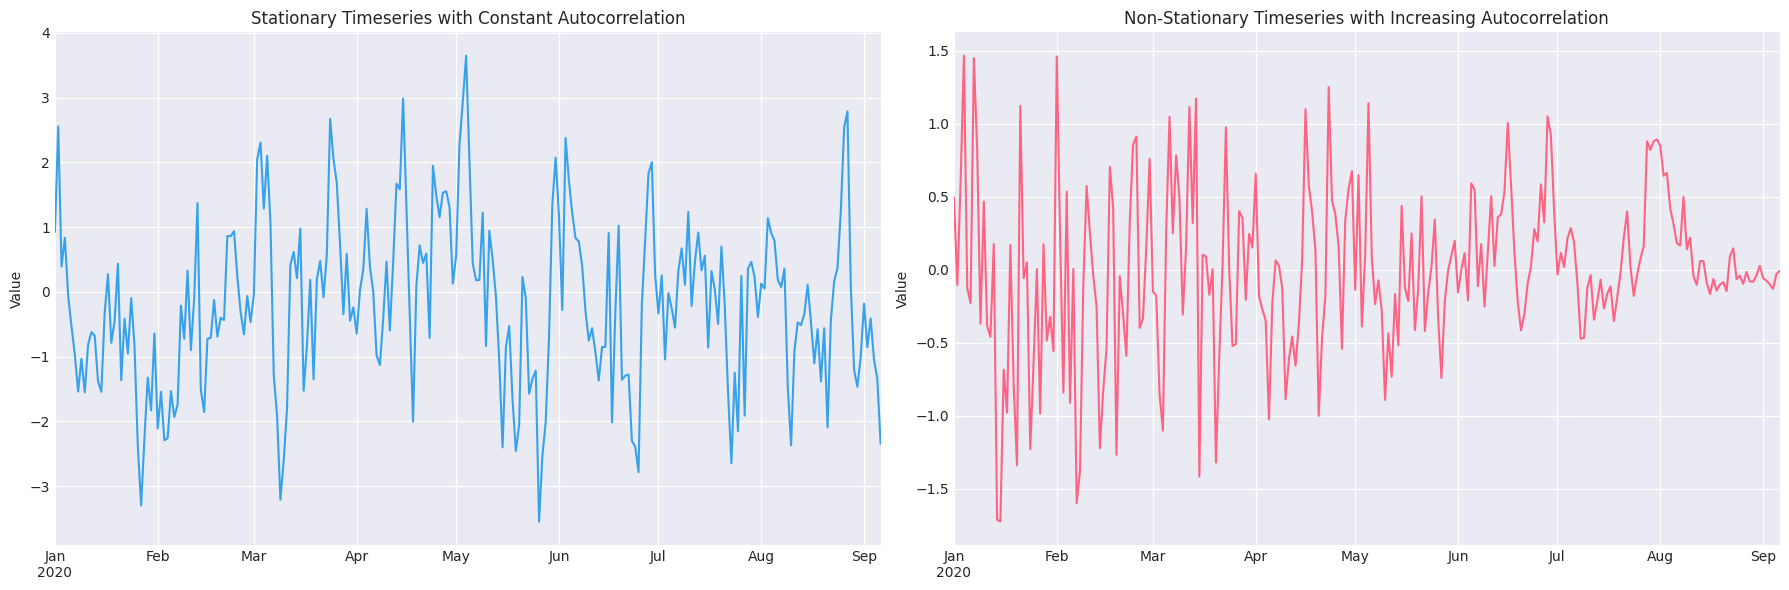

In [15]:
from statsmodels.tsa.arima_process import ArmaProcess

# Use a consistent plotting style
plt.style.use('seaborn-v0_8-darkgrid')

# Define a date range for the time series
prd_len = 250
dates = pd.date_range(start='2020-01-01', periods=prd_len, freq='D')

# --- Time Series with Constant Autocorrelation (AR(1) Process) ---
# For a simple AR(1) process, the moving-average component is 1.
ar_params_const = [1, -0.7]  # Coefficient for lag 1 is -0.7
ma_params_const = [1]
ar_const_process = ArmaProcess(ar_params_const, ma_params_const)
ts_const_ac = pd.Series(ar_const_process.generate_sample(nsample=prd_len, scale=1.0), index=dates)

# --- Time Series with Increasing Autocorrelation ---
# Initialize the series with some noise
np.random.seed(42)
ts_increasing_ac_list = [np.random.normal(0, 1)]

# Loop to build the series with an increasing autocorrelation coefficient
alpha = np.linspace(0.05, 0.95, prd_len)
for i in range(1, prd_len):
    # Current value is a combination of the previous value (with increasing weight)
    # and a new random noise term.
    new_val = alpha[i] * ts_increasing_ac_list[-1] + (1 - alpha[i]) * np.random.normal(0, 1)
    ts_increasing_ac_list.append(new_val)

# Convert the list to a Pandas Series with the date index before plotting
ts_increasing_ac = pd.Series(ts_increasing_ac_list, index=dates)

# --- Plot the Time Series side-by-side ---
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Plot 1: Constant Autocorrelation Time Series
ts_const_ac.plot(ax=axes[0], color='#36A2EB')
axes[0].set_title('Stationary Timeseries with Constant Autocorrelation')
axes[0].set_ylabel('Value')

# Plot 2: Increasing Autocorrelation Time Series
ts_increasing_ac.plot(ax=axes[1], color='#FF6384')
axes[1].set_title('Non-Stationary Timeseries with Increasing Autocorrelation')
axes[1].set_ylabel('Value')

plt.tight_layout()
plt.show()


## Transforming Non-Stationary Series into Stationary Ones

In order to use an ARIMA model to forecast non-stationary series, we must first transform the timeseries into a stationary one. The are many types of tranforms, although luckily the simplest (i.e., differences) is often the best:

* **Differencing**: Subtract the prior value from each value in a timeseries: $\dot{y}_{t} = y_t - y_{t-1}$
* **Proportional Change**: Compare the proportional difference of each timeseries value compared with the last: `df.col.shift(1)/df.col`
* **Rooting**: Taking the square root of the data (positive timeseries values only): `np.sqrt(df.col)`
* **Logging**: Taking the log of the data (positive timeseries values only): `np.log(df.col)`
* **Log-Return**: Popular in stock timeseries data, taking the logarithm of the proportional change, $LR(y_t) = \log\left(\frac{y_t}{y_{t-1}}\right)$


Note that for differencing and proportional change comparisons, the first value in the timeseries will be null having no prior value to compare with. Also, an initial value must be retained in order to reconstruct the original timeseries data from the _station-ized_ data.

Let us practice making data stationary on the population data for Salt Lake City between 1900 and 2020. First, observe the non-stationary growth of people in the Salt Lake City metropolitan area:

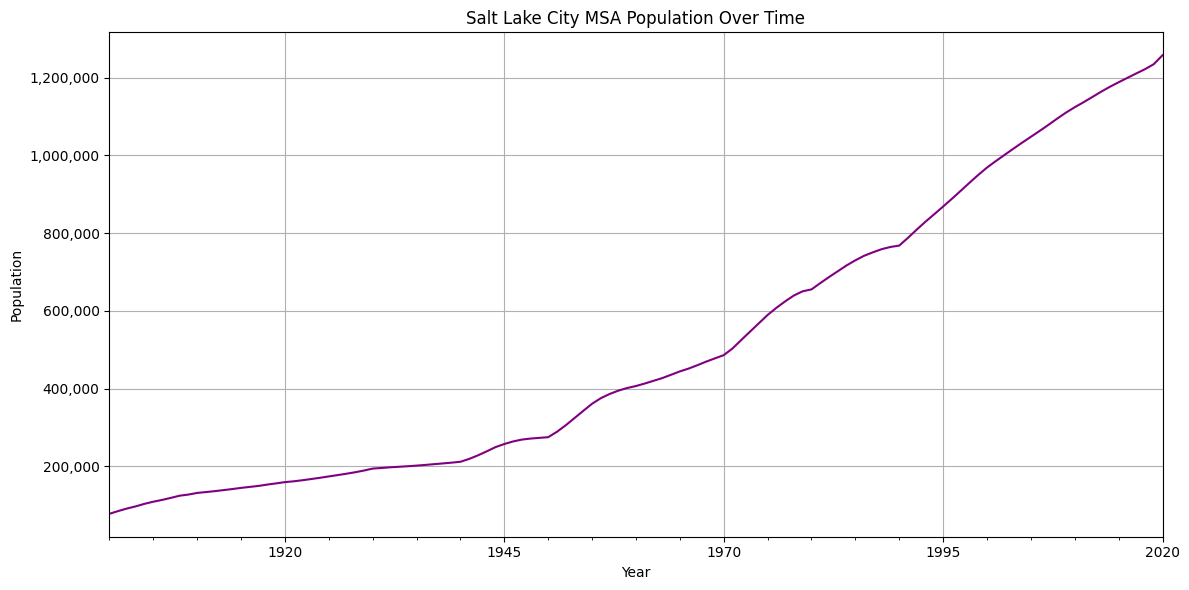

In [3]:
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

# Load the data and ensure correct data types
slc_pop_df = pd.read_csv(
    'DATA/salt_lake_city_population.csv'
)

#Correctly parse the 'Year' column using pd.to_datetime with format='%Y'
slc_pop_df['Year'] = pd.to_datetime(slc_pop_df['Year'], format='%Y')
slc_pop_df.set_index('Year', inplace=True)

# Create the plot using pandas, and get the matplotlib axes object
fig, ax = plt.subplots(figsize=(12, 6))

slc_pop_df.plot(
    ax=ax,
    title='Salt Lake City MSA Population Over Time',
    legend=False,
    color='purple'
)

# Define a function to format the y-axis (population) into thousands.
def formatter(x, pos):
    """Formats a number with a thousands separator."""
    return f"{x:,.0f}"

# Apply the formatter to the y-axis and set the label.
ax.yaxis.set_major_formatter(ticker.FuncFormatter(formatter))
ax.set_ylabel('Population')
ax.set_xlabel('Year')

# Ensure a clean layout and display the final plot.
plt.grid(True)
plt.tight_layout()
plt.show()

The above population growth series has a clear growth trend that is non-stationary. Simply taking a difference of this growth trend will not be sufficient to achieve stationarity as the resulting timeseries variance becomes larger as the city grows. The red-shading indicates a lower-variance early period compared with later growth. And, even the differences have a non-stationary positive trend past 1940:

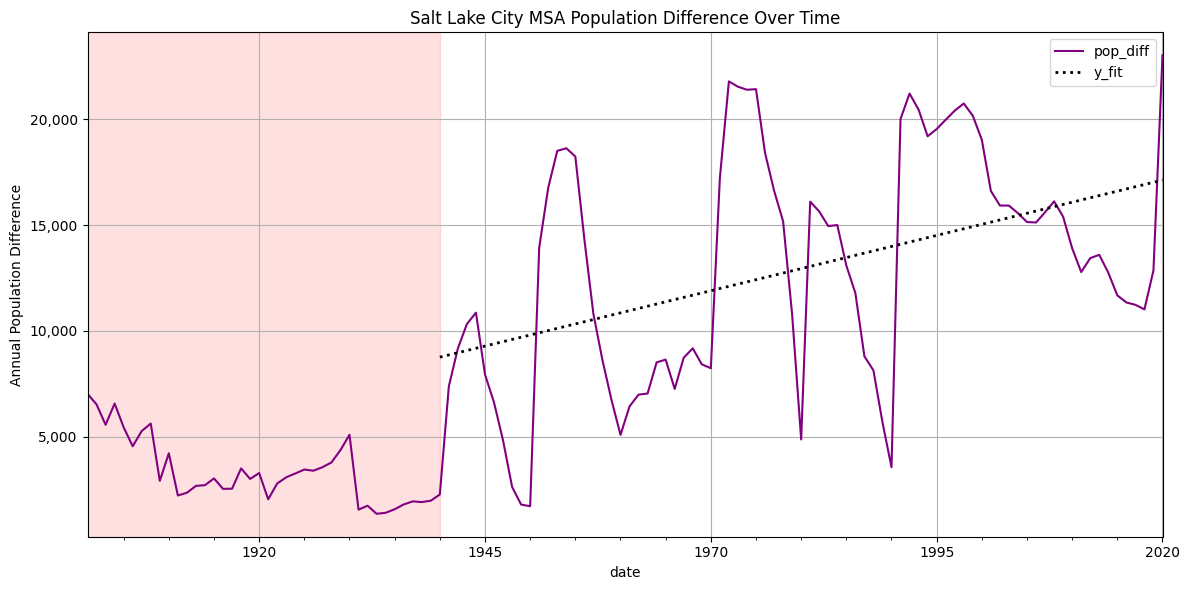

In [ ]:
import statsmodels.api as sm
import matplotlib.dates as mdates

slc_pop_df['pop_diff'] = slc_pop_df.Population.diff()

# Create the plot using pandas, and get the matplotlib axes object
fig, ax = plt.subplots(figsize=(12, 6))

slc_pop_df.pop_diff.dropna().plot(
    ax=ax,
    title='Salt Lake City MSA Population Difference Over Time',
    legend=True,
    color='purple'
)

# Apply the formatter to the y-axis and set the label.
ax.yaxis.set_major_formatter(ticker.FuncFormatter(formatter))
ax.set_ylabel('Annual Population Difference')
ax.set_xlabel('Year')

# Shade the historical period: from the first year in the data until 1940
start = slc_pop_df.index.min()
end = pd.to_datetime('1940', format='%Y')
ax.axvspan(start, end, color='red', alpha=0.12)

# Regression window
reg_start = pd.to_datetime('1940', format='%Y')
reg_end = pd.to_datetime('2020', format='%Y')
reg_series = slc_pop_df.pop_diff.loc[reg_start:reg_end].dropna()

# convert dates to numeric for regression (days since epoch)
x_num = mdates.date2num(reg_series.index.to_pydatetime()) # type: ignore
y_vals = reg_series.values

# design matrix with intercept
X = sm.add_constant(x_num)
model = sm.OLS(y_vals, X).fit()
# slope expressed per year (approx)
slope_per_day = model.params[1]
slope_per_year = slope_per_day * 365.25

# smooth fit line across the regression window
x_dates = reg_series.index         # list of datetime.datetime
y_fit = model.predict(X)
df_fit = pd.DataFrame({
    'date': pd.to_datetime(x_dates),
    'y_fit': y_fit
}).set_index('date').plot(
    ax=ax,
    color='black',
    linestyle=':',
    linewidth=2,
    label=f'Regression fit (1940-2020), slope={slope_per_year:.4f}/yr'
)

# Ensure a clean layout and display the final plot.
plt.grid(True)
plt.tight_layout()
plt.show()


In this case, differencing over time did not completely remove a trend, and results in a timeseries with increasing variance over time. Instead, let us try a proportional comparison transform to see if we can make these data stationary:

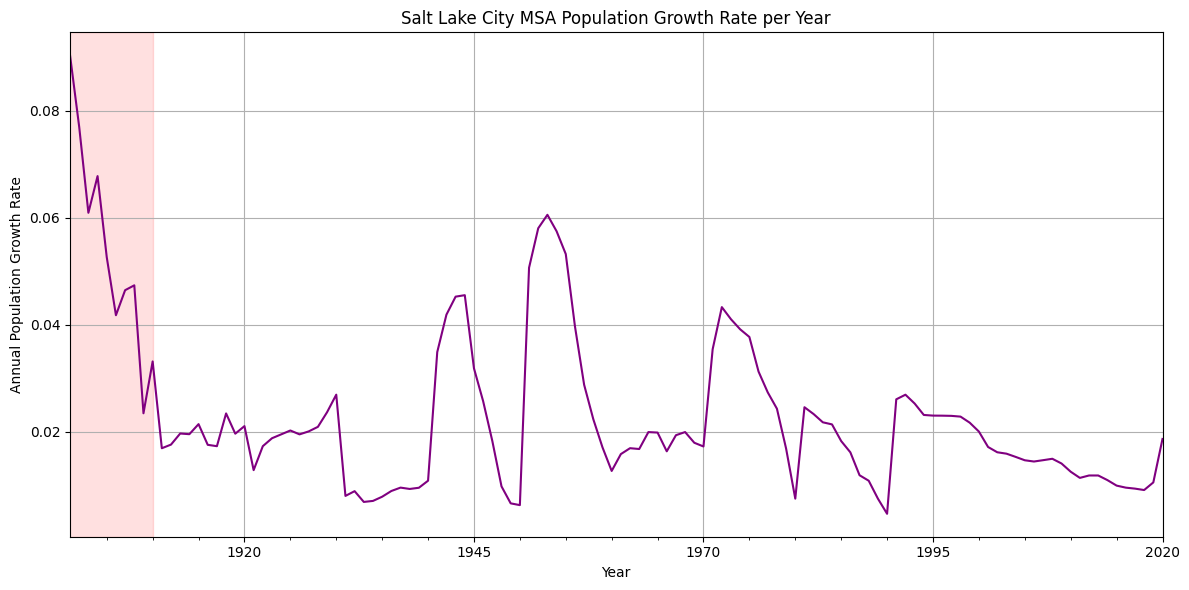

In [19]:
slc_pop_df['pop_prop_diff'] = slc_pop_df.Population.pct_change()

# Create the plot using pandas, and get the matplotlib axes object
fig, ax = plt.subplots(figsize=(12, 6))

slc_pop_df.pop_prop_diff.dropna().plot(
    ax=ax,
    title='Salt Lake City MSA Population Growth Rate per Year',
    legend=False,
    color='purple'
)

# Apply the formatter to the y-axis and set the label.
ax.set_ylabel('Annual Population Growth Rate')
ax.set_xlabel('Year')

# Shade the historical period: from the first year in the data until 1910
start = slc_pop_df.index.min()
end = pd.to_datetime('1910', format='%Y')
ax.axvspan(start, end, color='red', alpha=0.12)

# Ensure a clean layout and display the final plot.
plt.grid(True)
plt.tight_layout()
plt.show()

The above proportional tranformation of Salt Lake City's annual population data successfully removes the trend from the data, _for the most part_. There still remain a trend in the first 10 years of growth (indicated by red-shading) and these transformed data potentially have non-constant variance.

Sometimes multiple differences can succeed where a single diff fails as ours did above:

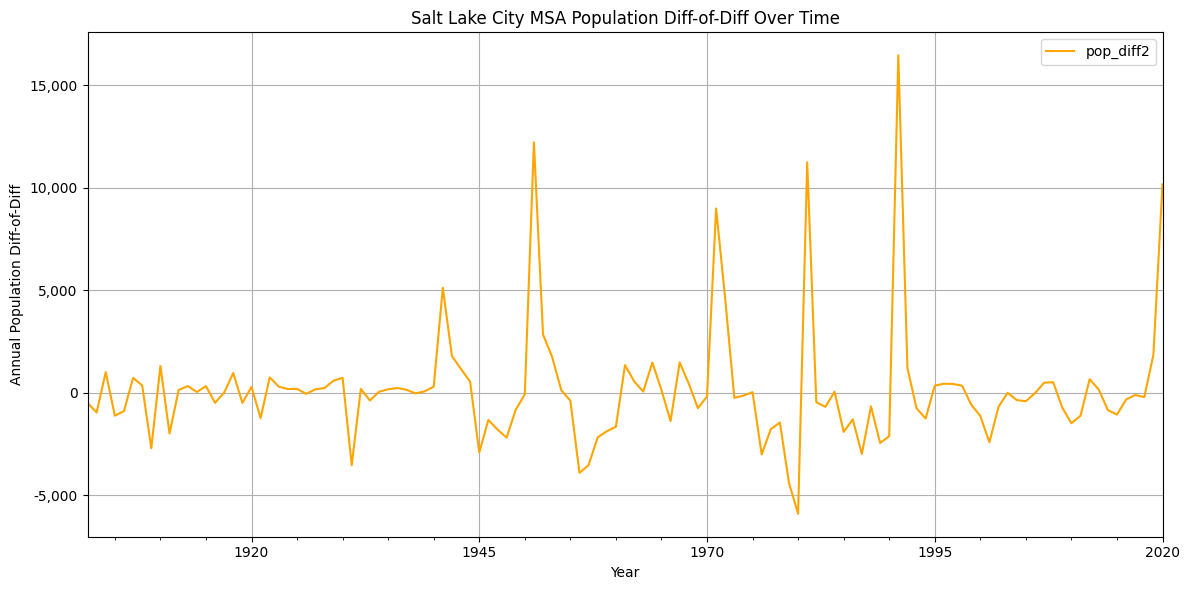

In [21]:
slc_pop_df['pop_diff2'] = slc_pop_df.Population.diff().diff() #double diff

# Create the plot using pandas, and get the matplotlib axes object
fig, ax = plt.subplots(figsize=(12, 6))

slc_pop_df.pop_diff2.dropna().plot(
    ax=ax,
    title='Salt Lake City MSA Population Diff-of-Diff Over Time',
    legend=True,
    color='orange'
)

# Apply the formatter to the y-axis and set the label.
ax.yaxis.set_major_formatter(ticker.FuncFormatter(formatter))
ax.set_ylabel('Annual Population Diff-of-Diff')
ax.set_xlabel('Year')

# Ensure a clean layout and display the final plot.
plt.grid(True)
plt.tight_layout()
plt.show()

The double diff-of-diffs SLC population data is much closer to stationary than other approaches tried above. The challenges faced here in tranforming these data are an example of those faced using ARIMA to model real world timeseries data.

# The Components of (S)AR(I)MA(X) Models

Let us study the AR and MA components first and come back for the I(ntegrated). ARMA models are the generic form of subtypes ARIMA & ARIMAX.

## Auto Regressive Component (AR)

Put simply, future values are modelled as dependent on past values. An auto-regressive (AR) model uses lagged time values of an outcome variable ($y$) as _predictors_ of $y$ at time $t$. An AR of _order_ $p$ [i.e., AR(p)] is represented as the following:

$$
y_t = a_1y_{t-1} + a_2y_{t-2} + \dots + a_ny_{t-p} + \epsilon
$$

## Moving Average Component (MA)

A moving average (MA) model regresses the values of the time series ($y_t$) against previous shock-values ($\epsilon_{t-q}$) of the same time series. A 1st-order MA model [MA(1)] looks like this:

$$
y_t = m_1\epsilon_{t-1} + \epsilon_t
$$

Or, generally for an order $q$ MA model:

$$
y_t = m_1\epsilon_{t-1} + m_2\epsilon_{t-2} + \dots + m_q\epsilon_{t-q} + \epsilon_t
$$

### ARMA Model

A combination of the AR and MA models. ARMA models are a general form that includes ARIMA & ARIMAX subtypes. These models are defined using an order of $p$ and $q$:

* $p$ is the order of the AR components
* $q$ is the order of the MA components

A general definition of an ARMA($p, q$) model:

$$
y_t = a_1y_{t-1} + a_2y_{t-2} + \dots + a_ny_{t-p} + m_1\epsilon_{t-1} + m_2\epsilon_{t-2} + \dots + m_q\epsilon_{t-q} + \epsilon_t
$$

#### Creating ARMA Data

Say we would like create sample data for the following ARMA model:

$$
y_t = 0.5y_{t-1} + 0.2\epsilon_{t-1} + \epsilon_t
$$

We can very simply create these data using `statsmodels`:

In [ ]:
from statsmodels.tsa.arima_process import arma_generate_sample
ar_coefs = [1, -0.5]  # AR(1) with coefficient 0.5, note the negative sign
ma_coefs = [1, 0.2]  # MA(1) with coefficient 0.2
n_samples = 1000
simulated_data = arma_generate_sample(ar=ar_coefs, ma=ma_coefs, nsample=n_samples)
ts_simulated = pd.Series(simulated_data, index=pd.date_range(start='2020-01-01', periods=n_samples, freq='D'))

## Integrated (I) Component: Differencing to Achieve Stationarity

A timeseries may be _integrated_ by differencing in order to achieve stationary data on which to model and forecast. Differencing may be required multiple times in order to achieve a stationary process. The number of required differences to be taken is called the _order_ of differences.

The following airline passenger data is differenced to achieve a neutral trend: 

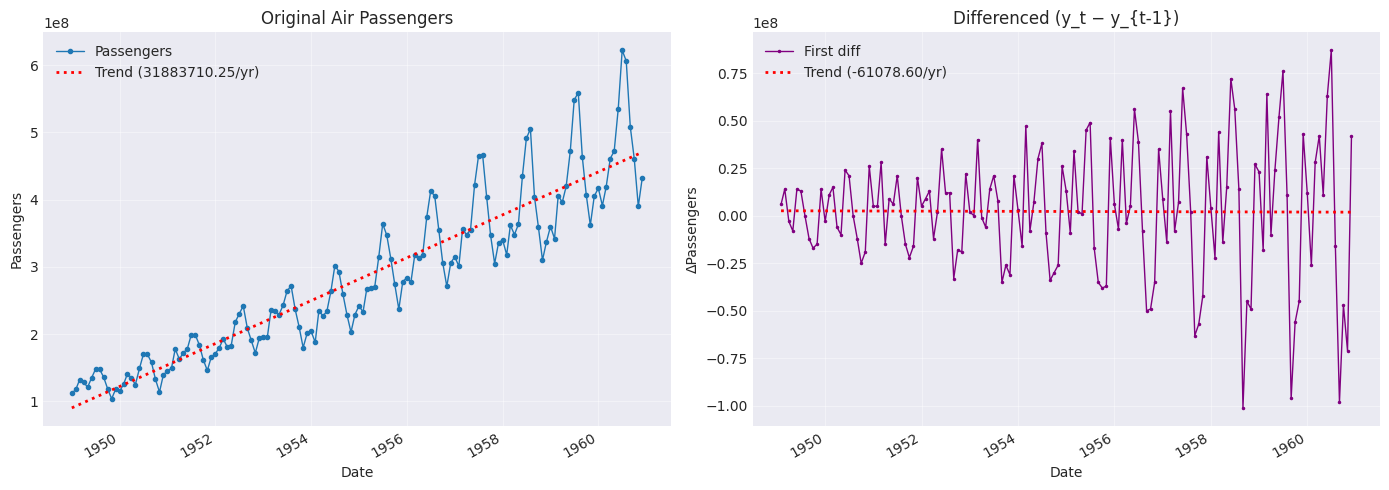

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Reload cleanly and choose the value column robustly
ap_df = pd.read_csv("DATA/air_passengers.csv", parse_dates=["ds"])
ap_df = ap_df.dropna(subset=["ds"]).set_index("ds").sort_index()

# Pick the correct value column and coerce to float
value_col = "global_passengers" if "global_passengers" in ap_df.columns else ("y" if "y" in ap_df.columns else None)
if value_col is None:
    raise ValueError("No numeric passenger column found; expected 'global_passengers' or 'y'.")

# Handle commas/strings and ensure float64
ap_df[value_col] = (
    ap_df[value_col]
      .astype(str)
      .str.replace(",", "", regex=False)
      .str.strip()
)
ap_df[value_col] = pd.to_numeric(ap_df[value_col], errors="coerce").astype("float64")

# Now compute diff and fit trends with guards
ap_df["diff"] = ap_df[value_col].diff()

def fit_linear_trend(series):
    s = series.dropna()
    if s.empty:
        return None
    x_num = mdates.date2num(s.index.to_pydatetime())
    y = s.values.astype(float)
    z = np.polyfit(x_num, y, 1)
    p = np.poly1d(z)
    x_fit = np.linspace(x_num.min(), x_num.max(), 200)
    return {
        "slope_per_year": float(z[0]) * 365.25,
        "dates_fit": mdates.num2date(x_fit),
        "y_fit": p(x_fit),
    }

orig_trend = fit_linear_trend(ap_df[value_col])
diff_trend = fit_linear_trend(ap_df["diff"])

# Side-by-side plot with trend overlays
plt.style.use("seaborn-v0_8-darkgrid")
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

# Original
ax = axes[0]
ax.plot(ap_df.index, ap_df[value_col].values, "o-", ms=3, lw=1, color="tab:blue", label="Passengers")
if orig_trend is not None:
    ax.plot(orig_trend["dates_fit"], orig_trend["y_fit"], "r:", lw=2, label=f"Trend ({orig_trend['slope_per_year']:.2f}/yr)")
ax.set_title("Original Air Passengers"); ax.set_xlabel("Date"); ax.set_ylabel("Passengers")
ax.legend(loc="best"); ax.grid(True, alpha=0.4)

# Differenced
ax = axes[1]
ax.plot(ap_df.index, ap_df["diff"].values, ".-", ms=3, lw=1, color="purple", label="First diff")
if diff_trend is not None:
    ax.plot(diff_trend["dates_fit"], diff_trend["y_fit"], "r:", lw=2, label=f"Trend ({diff_trend['slope_per_year']:.2f}/yr)")
ax.set_title("Differenced (y_t − y_{t-1})"); ax.set_xlabel("Date"); ax.set_ylabel("ΔPassengers")
ax.legend(loc="best"); ax.grid(True, alpha=0.4)

for ax in axes:
    loc = mdates.AutoDateLocator(minticks=3, maxticks=8)
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
    for t in ax.get_xticklabels():
        t.set_rotation(30); t.set_horizontalalignment("right")

plt.tight_layout()
plt.show()

## Exogenous Variables

Exogenous (from the greek roots for **ex**ternal & **gen**erated) variables may be added in an ARMA**X** timeseries model similar to how they would be added to an ordinary linear model. Essentially, ARMAX models are a combination of ARMA models & linear regression. These variables can substantially improve the predictive power of these models. However, there is a catch: finding independent variables for each outcome $y_t$ at each time $t$ can be tricky, and finding future values for these exogenous variables in order to produce ARIMA forecasts poses an additional challenge (or an additional forecasting problem).

A generic ARMAX model with exogenous variable $x_1$ and first-order AR ($p=1$) and MA ($q=1$) hyperparameters takes the following form:

$$
y_t =  \beta_1x_1 + a_1y_{t-1} + m_1\epsilon_{t-1} + \epsilon_t
$$



## Seasonality

Seasonality refers to a regular trend (i.e., slope) patterns that occur in the data over fixed time periods (e.g., weekly, monthly, annually). These patterns may be modeled with a modified approach to ARMA models. This specialized modeling approach is often referred to as SAR(I)MA(X).

This passenger airline passenger timeseries dataset exhibits classic seasonal patterns:

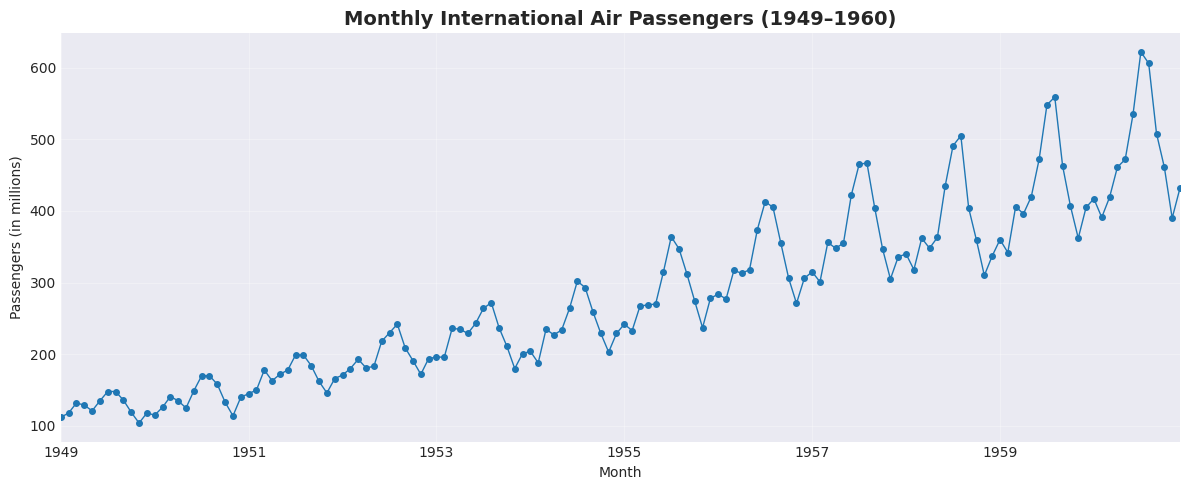

In [4]:
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

# Load CSV and parse the 'ds' date column
df = pd.read_csv("DATA/air_passengers.csv", parse_dates=["ds"])

# Set the datetime index and select the value column
df.set_index("ds", inplace=True)
series = df["y"].astype(float)

# Plot style and figure
plt.style.use("seaborn-v0_8-darkgrid")
fig, ax = plt.subplots(figsize=(12, 5))

# Plot the series with markers for readability
series.plot(ax=ax, color="tab:blue", linewidth=1, marker="o", markersize=4)

# Titles and labels
ax.set_title("Monthly International Air Passengers (1949–1960)", fontsize=14, weight="bold")
ax.set_xlabel("Month")
ax.set_ylabel("Passengers (in millions)")

# Format y-axis with thousands separator
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x):,}"))

# Optional: minor ticks every 3 months for reference
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1,4,7,10]))
ax.grid(True, which="major", alpha=0.3)

plt.tight_layout()
plt.show()


# Fitting ARIMA Models

The `statsmodels` package comes with an ARIMA object that may be hyper-parameterized and fit with timeseries data in order to make a forecast. As a reminder, the 3-main hyperparameters are:

* `p`: the order of lag variables autocorrelated with the outcome variable
* `i`: the order of differences to be taken on the input timeseries in order to make it stationary
* `q`: the order of the lag error terms (i.e., moving-average/shock terms) related to the outcome variable

Each of the component AR, MA models may be built by setting the other hyperparameters to zero:

* `ar_model = ARIMA(timeseries, order=(p,0,0))`
* `ma_model = ARIMA(timeseries, order=(0,0,q))`
* `arma_model = ARIMA(timeseries, order=(p,0,q))`

In order to determine the order of these hyperparameters, we must evaluate the lag autocorrelation, lag error correlation, and stationarity of the input timeseries.

Models may be `.fit()`, and the results may be `.summary()` as is convention in `statsmodels`. Note that `sigma2` is the variance of the shock terms.

## Checking for Stationarity

It is crucial to understand that ARMA models are assuming constant autocorrelation & variance along with an assumption of zero-trend. The first step in any model fitting with ARMA is determining determining that our input data is stationary, and whether it can be transformed to be stationary.



### Augmented Dicky-Fuller Test

A test for _trend_ & _variance_ non-stationarity (i.e., this test does not provide evidence regarding autocorrelation stationarity). The null hypothesis of this test is that the timeseries is _non-stationary_. This statistical test can be implemented with `statsmodels`:

In [ ]:
from statsmodels.tsa.stattools import adfuller

def print_adfuller(
    adftest_result: tuple,
    title: str = "",
    crit_val_percent: str = '5',
) -> None:
    """
    Prints formatted results of the Augmented Dickey-Fuller (ADF) test,
    with an adjustable critical value for the conclusion.

    Args:
        adftest_result (tuple): The tuple returned by statsmodels.tsa.stattools.adfuller.
        title (str): An optional title for the results.
        crit_val_percent (str): The critical value percentage to use for the conclusion
                                (e.g., '1', '5', or '10'). Defaults to '5'.
    """
    print("="*60)
    if title:
        print(f"Augmented Dickey-Fuller Test Results: {title}")
    else:
        print("Augmented Dickey-Fuller Test Results:")
    print("="*60)

    # Extract results from the tuple
    adf_statistic = adftest_result[0]
    p_value = adftest_result[1]
    lags_used = adftest_result[2]
    n_observations = adftest_result[3]
    critical_values = adftest_result[4]

    # Print with headers
    print(f"ADF Test Statistic:      {adf_statistic:.5f}")
    print(f"P-value:                 {p_value:.5f}")
    print(f"Number of Lags Used:     {lags_used}")
    print(f"Number of Observations:  {n_observations}")

    print("\nCritical Values:")
    for key, value in critical_values.items():
        print(f"    {key:<10}: {value:.5f}")
    print("="*60)

    # Determine the conclusion based on the specified critical value
    key = f"{crit_val_percent}%"
    if key in critical_values:
        if adf_statistic < critical_values[key]:
            print(
                f"Conclusion: Reject the null hypothesis (H0) at the "
                f"{crit_val_percent}% significance level."
                f"\nThe time series is likely stationary."
            )
        else:
            print(
                f"Conclusion: Fail to reject the null hypothesis (H0) at the "
                f"{crit_val_percent}% significance level."
                f"\nThe time series is likely non-stationary."
            )
    else:
        print(f"Warning: Critical value for '{key}' not found in results.")
        if p_value <= (int(crit_val_percent) / 100):
            print("Conclusion based on P-value: Likely stationary.")
        else:
            print("Conclusion based on P-value: Likely non-stationary.")
    print("="*60)

print_adfuller(adfuller(ts_zero_trend), title="ADF Statistic for a Trend-Stationary Series")

Augmented Dickey-Fuller Test Results: ADF Statistic for a Trend-Stationary Series
ADF Test Statistic:      -42.76639
P-value:                 0.00000
Number of Lags Used:     0
Number of Observations:  1825

Critical Values:
    1%        : -3.43394
    5%        : -2.86313
    10%       : -2.56761
Conclusion: Reject the null hypothesis (H0) at the 5% significance level.
The time series is likely stationary.


In [ ]:
print_adfuller(adfuller(ts_positive_trend), title="ADF Statistic for a Positive Trend Series")

Augmented Dickey-Fuller Test Results: ADF Statistic for a Positive Trend Series
ADF Test Statistic:      -2.72336
P-value:                 0.07008
Number of Lags Used:     25
Number of Observations:  1800

Critical Values:
    1%        : -3.43399
    5%        : -2.86315
    10%       : -2.56763
Conclusion: Fail to reject the null hypothesis (H0) at the 5% significance level.
The time series is likely non-stationary.


The more negative the ADF statistic, the more evidence the timeseries provides for rejecting the null-hypothesis (i.e., $H_0$: non-stationary trend). Remember that the augmented Dickey-Fuller _only_ tests for trend stationarity! It is possible for non-stationary series in terms of time-dependent variance, or dynamic auto-correlation; to pass the Dickey-Fuller.

## ARMAX Models

The "X" is for eXogenous. This ARMA variant uses other _exogenous_ variables in addition the timeseries values in order to predict the timeseries outcome. Exogenous variables may be added to `statsmodels` ARIMA objects with the `exog` parameter:

In [ ]:
armax_model = ARIMA(df.timeseries, order = (p,0,q), exog=df.exog)

# ARIMA Term Definitions

* **Cyclicality**: A repeating pattern of variation but without a fixed period
* **(Model) Order**: The _order_ of a model is an integer indicating the number of time-lags used
* **Timeseries**: A series of data points indexed in time order
* **Trend**: The average slope over a given time period
* **Seasonality**: Patterns of variation that repeat across fixed periods (e.g., daily, weekly, etc.)
* **White Noise**: A series whose values have a mean of zero, constant variance (maybe), and are not auto-correlated across time

# References

* DataCamp Resources:
    - ARIMA for Time Series Forecasting: [https://www.datacamp.com/tutorial/arima](https://www.datacamp.com/tutorial/arima)
    - ARIMA Models in Python: [https://app.datacamp.com/learn/courses/arima-models-in-python](https://app.datacamp.com/learn/courses/arima-models-in-python)
* Geeks for Geeks: ARIMA Model for Time Series Forecasting: [https://www.geeksforgeeks.org/machine-learning/python-arima-model-for-time-series-forecasting/](https://www.geeksforgeeks.org/machine-learning/python-arima-model-for-time-series-forecasting/)